# FalconAI - Test 1 : Implementation du modèle dynamique brut

In [43]:
import numpy as np
import os 
import tqdm

In [113]:
def Poussee(alpha, beta, thr, T):
    """Calcul de la poussée du moteur principal dans le repère de la fusée
    alpha : rotation autour de x_f
    beta : rotation autour de y_f
    thr : throttle du moteur en %
    T : poussée nominale de la fusée en N
    Wiki matrice de rotation https://fr.wikipedia.org/wiki/Matrice_de_rotation
    
    """
    
    F = thr/100*np.array((0,0,T))
    alpha = np.radians(alpha)
    beta = np.radians(beta)
    
    R_x = np.array(( (1, 0, 0),
                    (0, np.cos(alpha), -np.sin(alpha)),
                    (0, np.sin(alpha),  np.cos(alpha)) ))
    
    R_y = np.array(((np.cos(beta), 0, np.sin(beta)),
                    (0, 1, 0),
                    (-np.sin(beta), 0,  np.cos(beta)) ))
    
    F_f = np.dot(R_y,np.dot(R_x, F))
    
    return(F_f)
    
#Poussee(3, 2, 50, 25000)

In [114]:
def RPFD(F_f, D_f, I, m):
    """
    Calcul du Principe de Fondamental de la Dynamique 
    F_f : Poussée orientée du booster dans le repère de la fusée (en N)
    D_f : Vecteur point de poussée - CDG dans le repère de la fusée (en N)
    I : Inertie du booster autour de son CDG 
    m : masse du booster (en kg)
    """
    
    x_pp = F_f / m
    
    M_f_CDG = np.cross(D_f, F_f)
    theta_pp = M_f_CDG / I
    #print('x_pp = {}'.format(x_pp))
    #print('theta_pp = {}'.format(theta_pp))
    #print(np.array([x_pp, theta_pp]))
    return np.array([x_pp, theta_pp])

In [115]:
def coord_local2global(vectors, state):
    """
    Recalcul des vecteurs dans le référentiel terrestre
    vectors : série de vecteurs dans le référentiel de la fusée
    state : état de la fusée dans les coordonnées du référentiel terrestre
    """
    assert vectors.shape[-1]==3, 'l`algo attend une suite de vecteurs 3D'
    # assert len(state) == 6, 'l algo attend le vecteur état de la fusée dans le référentiel terrestre'
    
    alpha, beta, gamma = state[0:3, -1] * np.pi / 180
    
    R_x = np.array(( (1, 0, 0),
                    (0, np.cos(alpha), -np.sin(alpha)),
                    (0, np.sin(alpha),  np.cos(alpha)) ))
    
    R_y = np.array(((np.cos(beta), 0, np.sin(beta)),
                    (0, 1, 0),
                    (-np.sin(beta), 0,  np.cos(beta)) ))
    
    R_z = np.array(((np.cos(gamma), - np.sin(gamma), 0),
                    (np.sin(gamma), np.cos(gamma), 0),
                    (0, 0, 1) ))
    
    out=[]
    for vect in vectors:
        out.append(np.array(np.dot(R_z, np.dot(R_y, np.dot(R_x, vect)))))
    return np.array(out)

In [156]:
def integration(X_s, dt, x_s):
    
    """
    Intégration temporelle de l'accélération direction et angulaire 
    X_s : vecteur d'état mémoire de la trajectoire (en unité SI : degrès et mêtres) 
        série de vecteurs colonnes position, vitesse, accélération de taille 3 
    dt : temps d'intégration (s)
    x_s : vecteur d'état de la fusée dans le référentiel global (acceleration, acceleration angulaire)
    """
    
    #print('X_-1 = {}'.format(X_s[:, -1]))
    #print(X_s.shape)
    #print('x_s = {}'.format(x_s))
    #print(x_s.shape)
    #print(x_s[0])
    
    x_p = x_s[0] * dt + X_s[3:6, -1] 
    x = x_p * dt + X_s[0:3, -1]
    theta_p = x_s[1] * dt + X_s[12:15, -1]
    theta = theta_p * dt + X_s[9:12, -1]
    
    #print('x_p = {}'.format(x_p))
    #print('x = {}'.format(x))
    #print('theta_p = {}'.format(theta_p))
    #print('theta = {}'.format(theta))
    
    return np.c_[X_s, np.append(x, np.append(x_p, np.append(x_s[0], np.append(theta, np.append(theta_p, x_s[1])))))]

In [175]:
## test 1 

## Initialisation 
X = np.zeros((18, 1))
dt = 0.1
alpha = 0
beta = 0

# rocket characteristics
T = 8e6
thr=50
L = 70
r = 2.6
m_tot = 595000
I = np.array([ 1/12*m_tot*(3*r*r + L*L), 1/12*m_tot*(3*r*r + L*L), 1/2*m_tot*r*r])
D_f = np.array([0, 0, 35])

for i in range(100):
    
    F_f = Poussee(alpha, beta, thr, T)
    X_pp = RPFD(F_f, D_f, I, m_tot)
    X_pp = coord_local2global(X_pp, X)
    X = integration(X, dt, X_pp)
    
    if i==50:
        thr=0

In [176]:
X.shape

(18, 101)

In [171]:
import matplotlib.pyplot as plt

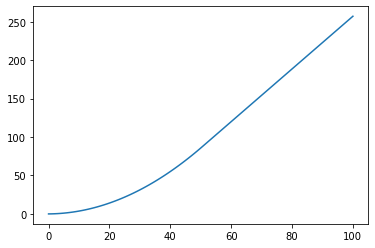

In [177]:
plt.plot(X[2, :])
plt.show()

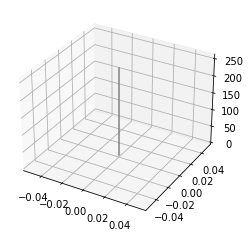

In [178]:
ax = plt.axes(projection='3d')
ax.plot3D(X[0, :], X[1, :], X[2, :], 'gray')